## 뉴스기사 요약해보기

## Step 1. 데이터 수집하기
---
- **headlines : 요약문**  
- **text : 원문**

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel0042/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
import urllib.request
#urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [7]:
#추출적 요약을 위해 새로운 데이터프레임을 만들어 준다.
data_pure = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [8]:
data.sample(10)

,headlines,text
27116,Union Minister Sinha garlands 8 Ramgarh lynchi...,Union Minister Jayant Sinha on Thursday met an...
90196,Royal Enfield engine was used in Rana's 'Baahu...,A Royal Enfield engine was used to power the b...
594,Apple AirPods may get 'Hey Siri' command suppo...,"Apple's next generation AirPods, which are rum..."
73434,Nearly 250 trains cancelled after riots in Pun...,Nearly 250 trains bound towards Punjab and Har...
96712,Four holy cities to get 24-hour power supply i...,"Ayodhya, Mathura, Varanasi and Gorakhpur, four..."
98229,"Early ATM was deemed a failure as hookers, gam...","The Bankograph, an early form of the ATM, is b..."
50550,Philippine Prez expresses interest in adopting...,Philippine President Rodrigo Duterte has expre...
3256,"George, last known Hawaiian land snail of its ...","George, the last known Hawaiian land snail of ..."
4111,Song 'Dilbar' was a turning point in my career...,Nora Fatehi has said that the song 'Dilbar' fr...
26227,Elon Musk says he might visit India next year,Tesla and SpaceX's billionaire CEO Elon Musk o...


In [9]:
len(data)

98401

## Step 2. 데이터 전처리하기(추상적요약)
  
### (1) 중복 샘플과 null 샘플 확인하고 제거하기
  
#### (1-1) 중복 제거
  
  
**`<!>`** 추출적 요약을 위한 데이터는 자연스러운 문장을 그대로 추출하기 위하여 중복데이터 null 데이터 제거 외에  
다른 전처리는 하지 않는다.**`<!>`**

In [16]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98262


In [17]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [18]:
#중복제거
data_pure['text'].nunique()

98360

In [19]:
data_pure.drop_duplicates(subset=['text'], inplace=True)

In [20]:
len(data_pure)

98360

#### (1-2) Null 샘플 제거
null 샘플 없음

In [21]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### (2) 텍스트 정규화와 불용어 제거
  
#### (2-1) 텍스트 정규화
정규화 사전 출처 : <a href='https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python'>Expanding English language contractions in Python</a>

In [22]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


#### (2-2) 불용어 처리
NLTK에서 제공하는 불용어 리스트를 사용한다.

In [23]:
print('불용어 개수 :', len(stopwords.words('english')))
print('\n',stopwords.words('english'))

불용어 개수 : 179

 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 

#### (2-3) 텍스트 전처리
**`Abstractive`** 한 요약문이 자연스러울려면 불용어 처리를 호출하지 않는 것이 좋다고 한다.

In [24]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=False):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [25]:
#함수 테스트
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.
print(preprocess_sentence(temp_summary, True))  # 불용어를 제거하였습니다.

everything bought was great infact ordered twice and the third ordered wasfor my mother and father
great way to start the day
great way start day


#### 원문은 불용어를 제거하고 요약문(headlines)은 불용어 처리를 하지 않는다.

In [26]:
#Text 전처리
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more',
 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharma captaincy after consecutive victories dating back to march the match witnessed india getting all out for their seventh lowest total

In [27]:
#요약문 전처리
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [28]:
#전처리로 완전히 다 소실되버린 문장들이 있는지 확인하기 위한 과정
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()

headlines    0
text         0
dtype: int64

### (3) 훈련데이터와 테스트데이터 나누기
  
#### (3-1) 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.180195201301345
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


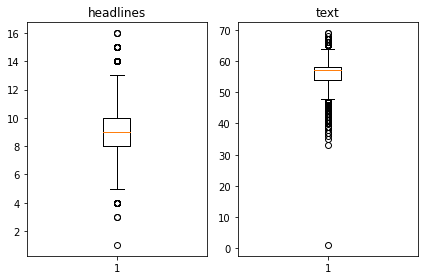

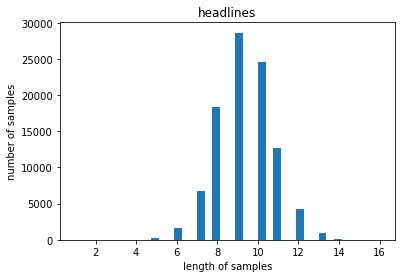

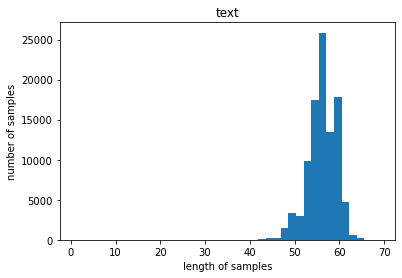

In [29]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')

plt.subplot(1,2,2)
plt.boxplot(text_len)

plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
#max 길이 임의로 설정하기
text_max_len = 60
headlines_max_len = 11

In [31]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [32]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9443777958519723
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [33]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88112


### (4) 시작토큰과 종료 토큰 추가하기
#### headlines가 요약문으로 사용될 것이므로 디코더에 들어갈 headlines 앞 뒤로 토큰을 붙여준다.

In [34]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
#eostoken이 있는게 타겟이된다.
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiit pg p...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan has deni...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu has said w...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


In [35]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### (5) 데이터 나누기

In [36]:
#인코더 갯수 즉 샘플 수 만큼 래인지 뽑기 일종의 인덱스 담기
indices = np.arange(encoder_input.shape[0])
#막 섞기
np.random.shuffle(indices)
print(indices)

[70877 58112 71707 ... 63325 46715 70596]


In [37]:
#막 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [38]:
#데이터 비율 8:2로 나누기
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 17622


In [39]:
#학습데이터와 테스트 데이터로 나누기
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 70490
훈련 레이블의 개수 : 70490
테스트 데이터의 개수 : 17622
테스트 레이블의 개수 : 17622


### (6) 정수 인코딩
단어집합 만들기 및 정수 인코딩

#### (6-1) 원문에 대한 토크나이징

In [40]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [41]:
threshold = 10 #등장 빈도수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67032
등장 빈도가 9번 이하인 희귀 단어의 수: 49403
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17629
단어 집합에서 희귀 단어의 비율: 73.70062059911685
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.090148456755841


In [42]:
src_vocab = 15000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 15,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [43]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1, 2758, 4206, 1131, 4, 29, 7, 271, 69, 387, 8, 780, 220, 6, 682, 1522, 1, 387, 1265, 173, 2, 1492, 43, 780, 407, 133, 431, 898, 4, 937, 2063, 1574, 5, 1, 1513, 3405, 6, 43, 2425, 1, 387, 39, 1265, 173, 2, 5495, 86, 7057, 10427, 220], [358, 1237, 1645, 4480, 7, 5000, 15, 1, 6355, 1658, 736, 7827, 2, 1169, 2425, 5104, 64, 1, 8225, 743, 103, 2, 1, 481, 4, 29, 783, 7255, 2361, 38, 12, 1, 48, 80, 1522, 41, 75, 835, 21, 4338, 6355, 4480, 7, 39, 3613, 2850, 5001, 2635, 2, 1169, 36, 1522, 5, 109, 828], [1, 190, 1239, 4, 7480, 1341, 962, 15, 1040, 269, 21, 283, 2185, 3, 69, 911, 6, 132, 112, 1455, 225, 5, 3322, 4595, 5681, 3887, 2426, 5, 7360, 4718, 2899, 1, 7151, 21, 1, 1040, 269, 44, 7360, 11, 243, 3, 673, 4339, 13, 4595, 5681, 1997, 1215, 2186, 13, 4141, 10199]]


#### (6-2) 요약문에 대한 토크나이징

In [44]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [45]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29135
등장 빈도가 5번 이하인 희귀 단어의 수: 19248
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9887
단어 집합에서 희귀 단어의 비율: 66.06487043075339
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.139134303514462


In [46]:
tar_vocab = 9800
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 21, 177, 264, 5, 336, 187, 7, 423], [1, 2602, 2726, 310, 6379, 3, 480, 1067, 11, 18, 5784], [1, 3482, 1301, 9, 849, 210, 11, 35, 1035, 354, 6380], [1, 62, 394, 17, 594, 227, 15, 182, 2099, 8952], [1, 7663, 6381, 5785, 1338, 668, 2181, 4, 370, 66]]
target
decoder  [[21, 177, 264, 5, 336, 187, 7, 423, 2], [2602, 2726, 310, 6379, 3, 480, 1067, 11, 18, 5784, 2], [3482, 1301, 9, 849, 210, 11, 35, 1035, 354, 6380, 2], [62, 394, 17, 594, 227, 15, 182, 2099, 8952, 2], [7663, 6381, 5785, 1338, 668, 2181, 4, 370, 66, 2]]


### (7) 학습을 위해 데이터 정제하기
빈도수가 낮은 단어를 삭제하는 과정에서 문장 전체가 통으로 날라가버릴 수가 있다.  
이런 문장은 null data이므로 삭제 해줘야한다.

In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 70489
훈련 레이블의 개수 : 70489
테스트 데이터의 개수 : 17622
테스트 레이블의 개수 : 17622


#### (7-1) 패딩하기

In [48]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기(추상적 요약)

In [50]:
#urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [51]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [52]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [53]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [54]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1920000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [65]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
276/276 [==============================] - 101s 366ms/step - loss: 6.0082 - val_loss: 5.6557
Epoch 2/50
276/276 [==============================] - 102s 369ms/step - loss: 5.4785 - val_loss: 5.2508
Epoch 3/50
276/276 [==============================] - 100s 363ms/step - loss: 5.1225 - val_loss: 4.9561
Epoch 4/50
276/276 [==============================] - 101s 364ms/step - loss: 4.8301 - val_loss: 4.7400
Epoch 5/50
276/276 [==============================] - 101s 367ms/step - loss: 4.5967 - val_loss: 4.5883
Epoch 6/50
276/276 [==============================] - 100s 363ms/step - loss: 4.4040 - val_loss: 4.4471
Epoch 7/50
276/276 [==============================] - 99s 359ms/step - loss: 4.2355 - val_loss: 4.3586
Epoch 8/50
276/276 [==============================] - 99s 360ms/step - loss: 4.0881 - val_loss: 4.2402
Epoch 9/50
276/276 [==============================] - 99s 360ms/step - loss: 3.9597 - val_loss: 4.1646
Epoch 10/50
276/276 [==============================] - 99s 359ms/st

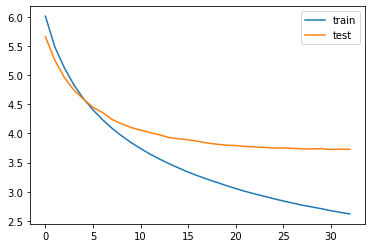

In [67]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기(추상적 요약)

### 인퍼런스 모델 구현
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야하므로,필요한 3개의 사전을 아래와 같이 미리 준비한다.

In [68]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [69]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [70]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [71]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트

In [72]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [74]:
for i in range(50, 55):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : rohan bopanna and his canadian mixed doubles partner defeated second seeds sania mirza and ivan in the quarterfinal of the french open on monday mirza was for her second mixed doubles title at roland while bopanna is on course to register his maiden mixed doubles french open title 
실제 요약 : bopanna ousts sania from french open with win in quarters 
예측 요약 :  bopanna enters the grand slam tennis open after


원문 : indian drug regulator central drugs standard control organization on tuesday said report that johnson johnson had known its baby powder has cancer causing was under consideration the powder samples were tested earlier but nothing wrong was found in them it added it is too early to say if formal investigation would be launched further said 
실제 요약 : baby powder report under indian regulator 
예측 요약 :  drug addiction firms have powder cancer drug


원문 : spanish national team goalkeeper david de has demanded public apology from spain prime minister pedro sanchez for commenting on

## Step 5. Summa을 이용해서 추출적 요약해보기

### 데이터 다운로드

In [75]:
import requests
from summa.summarizer import summarize

In [84]:
def extract_summarize(data, num_sample=5):
    sampel_data = data.sample(num_sample)
    
    for d in sampel_data.values:
        print('text:')
        print(d[1])
        print('\n headlines:')
        print(d[0])
        print('\n Summary:')
        print(summarize(d[1], ratio=0.5, split=True))
        print('\n')

In [86]:
extract_summarize(data_pure)

text:
Yahoo has agreed to pay $50 million in settlement for a security breach that affected around 200 million users in the US and Israel. Additionally, Yahoo will also offer up to $35 million compensation on lawyer fees and offer credit monitoring services to affected users for two years. The data stolen included users' names, email addresses and phone numbers.

 headlines:
Yahoo to pay $50mn for data breach affecting 200mn US users

 Summary:
['Yahoo has agreed to pay $50 million in settlement for a security breach that affected around 200 million users in the US and Israel.']


text:
Thousands of people on Tuesday participated in the funeral procession of soldiers martyred in the Sunjuwan Army camp attack, in different parts of J&K. A crowd gathering for a jawanÃ¢ÂÂs funeral procession shows they are ready to defy the terror organisations, officials said. The attack on the Army camp had resulted in the death of six soldiers and one civilian. 

 headlines:
Thousands attend funeral 

### 고찰
최근 영상에도 많은 시도와 좋은 성과를 보이고 있는 transformer의 전신인 Attention모델을  
직접 구현은 아니지만 API를 모델에 추가하여 사용해볼 수 있었다.  
  
뉴스 내용과 헤드라인 문장을 데이터로 사용하였고, 문장을 요약하여 얼마나 헤드라인과 비교하여 문장을  
잘 요약하는 모델을 구현해보는 것이 이번 토이프로젝트의 목표였다.  
  
자연어처리에는 많은 전처리 과정이 들어가고 번역이 요약과 같은 seq2seq 문제는 encoding decoding  
과 같은 낯설고 복잡한 개념이 들어가기 때문에 항상 프로젝트를 완성하기까지 시간이 많이 필요로 한다.  
  
EarlyStopping callback 함수를 사용하여 모델이 훈련데이터에 오버피팅하기 전에 학습을 멈추게 함으로써  
수치적으로는 학습이 잘 되었다고 평가할 수 있는 그래프를 얻은 것같다. 하지만 실제 요약문을 추출해보았을때는  
다소 아쉬움이 있었다.  
예를 들면

>실제 요약 : falling sea level caused to study  
>예측 요약 :  earth is the largest level than earth study
  
어텐션모델을 사용하여 추상적 요약을 하였을때 위와 같은 문장을 생성하였는데, 모델이 생성한 요약은 매우 추상적이고  
직관적이지 못한 것을 알 수 있다. 하지만 실제 요약문장에서와 비슷한 단어들을 여러개 사용하는 것이 여러 문장들에서  
확인되었다.  
  
단순 추출적 요약은 주어진 문장에서 어느정도의 비율로 문장을 뽑아 낼 것인가를 하나의 파라미터로 조절할 수 있으며,  
원문에서 있는 그대로 문장을 추출해온다.  
그래서 summa를 사용할때 입력 데이터로 아무런 정제를 하지않은 원문 그대로를 입력으로 주어서 최대한 요약문이  
사람이 읽기에 어색함이 없게 하였다.